# Quora Question Pair Similarity
### Kaggle Competition link: https://www.kaggle.com/c/quora-question-pairs

<p>Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.</p>

<p>Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.</p>

### Data fields
1. id - the id of a training set question pair
2. qid1, qid2 - unique ids of each question (only available in train.csv)
3. question1, question2 - the full text of each question
4. is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.


### Our strategy is:
1. Load the data  
2. High level EDA <br>
   a. Stats <br>
   b. Check missing values <br>
   c. Check duplicate values <br>
   d. Check unique values <br>
3. EDA
4. Preprocessing of text data <br>
   a. Lower casing <br>
   b. Remove HTML tags <br>
   c. Remove URLs <br>
   d. Expand contractions <br>
   e. Number to units <br>
   f. Remove punctuations <br>
   g. Remove stopwords <br>
   h. Lemmatization <br>
5. Export data

In [262]:
# Imports 

# General 
from datetime import datetime
from tqdm import tqdm

# Data
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Preprocessing
import string
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ParikshitShinge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1. Load data

In [6]:
start = datetime.now()

# Read data
data = pd.read_csv("../data/raw/train.csv", sep=",")
print('Data loading completed.\nTime taken: {0}'.format(datetime.now() - start))

Data loading completed.
Time taken: 0:00:01.151675


### 2. High level EDA
#### 1. Stats

In [7]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


#### 2. Check missing values

In [11]:
data.isnull().any()

id              False
qid1            False
qid2            False
question1        True
question2        True
is_duplicate    False
dtype: bool

In [18]:
data[(data.question1.isnull() | data.question2.isnull())]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [20]:
data_na_id = data[(data.question1.isnull() | data.question2.isnull())]['id'].values
print('IDs of the rows where either question1 or question2 is missing: {0}'.format(data_na_id))

IDs of the rows where either question1 or question2 is missing: [105780 201841 363362]


#### 3. Check duplicate values

In [25]:
# Duplicate rows
data[data.duplicated()]

,id,qid1,qid2,question1,question2,is_duplicate


In [34]:
# Duplicate question1 IDs
data.groupby(by='qid1')['question1'].nunique().sort_values(ascending=False)

qid1
1         1
343268    1
343280    1
343278    1
343276    1
         ..
163307    1
163305    1
163302    1
537932    1
493340    0
Name: question1, Length: 290654, dtype: int64

In [35]:
# Duplicate question2 IDs
data.groupby(by='qid2')['question2'].nunique().sort_values(ascending=False)

qid2
2         1
349044    1
349078    1
349075    1
349072    1
         ..
168136    1
168134    1
168132    1
168131    1
174364    0
Name: question2, Length: 299364, dtype: int64

#### 4. Check unique values

In [27]:
data.nunique()

id              404290
qid1            290654
qid2            299364
question1       290456
question2       299174
is_duplicate         2
dtype: int64

### 3. EDA

#### 1. Similar question pair

Total number of question pairs in train dataset: 404290
Total non-duplicates in train dataset: 255027 [63.08 %]
Total duplicates in train dataset: 149263 [36.92 %]


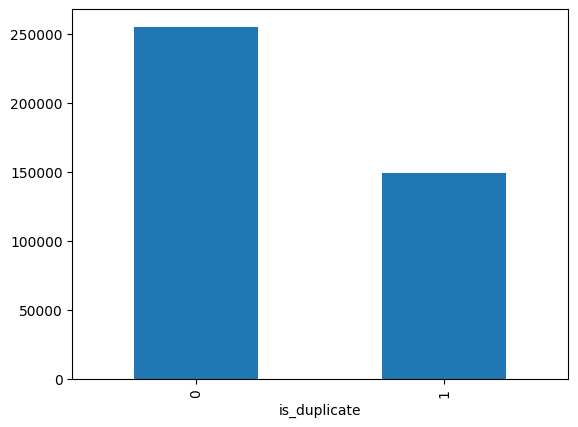

In [85]:
# Check target variable
print('Total number of question pairs in train dataset: {0}'.format(len(data)))
print('Total non-duplicates in train dataset: {0} [{1} %]'.format(data[data['is_duplicate']==0].groupby(by='is_duplicate')['is_duplicate'].count().values[0],
                                                                round(100 - data['is_duplicate'].mean()*100,2)))
print('Total duplicates in train dataset: {0} [{1} %]'.format(data[data['is_duplicate']==1].groupby(by='is_duplicate')['is_duplicate'].count().values[0],
                                                              round(data['is_duplicate'].mean()*100,2)))

data.groupby(by='is_duplicate')['is_duplicate'].count().plot.bar()
plt.show()

#### 2. Unique Vs Duplicated Questions

In [170]:
qids = pd.Series(data['qid1'].to_list() + data['qid2'].to_list())
unique_qids = len(np.unique(qids))
repeated_qids = np.sum(qids.value_counts()>1) #.where(lambda x : x != 0).dropna()

In [172]:
print('Total questions: {0}'.format(len(qids)))
print('Total unique questions: {0}'.format((unique_qids)))
print('Number of questions that are repeated more than once: {}'.format(np.sum(repeated_qids)))
print('Maximum number of times a question is repeated: {0}'.format(np.max(qids.value_counts())))

Total questions: 808580
Total unique questions: 537933
Number of questions that are repeated more than once: 111780
Maximum number of times a question is repeated: 157


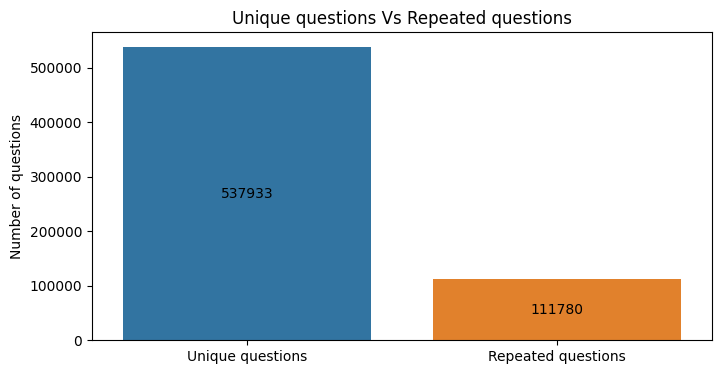

In [173]:
x = ['Unique questions', 'Repeated questions']
y = [unique_qids, repeated_qids]

fig = plt.figure(figsize=(8,4))
ax = sns.barplot(x=x,y=y)

ax.set_title('Unique questions Vs Repeated questions')
ax.set_ylabel('Number of questions')
ax.bar_label(ax.containers[0], label_type="center")

plt.show()

#### Repeated questions histogram

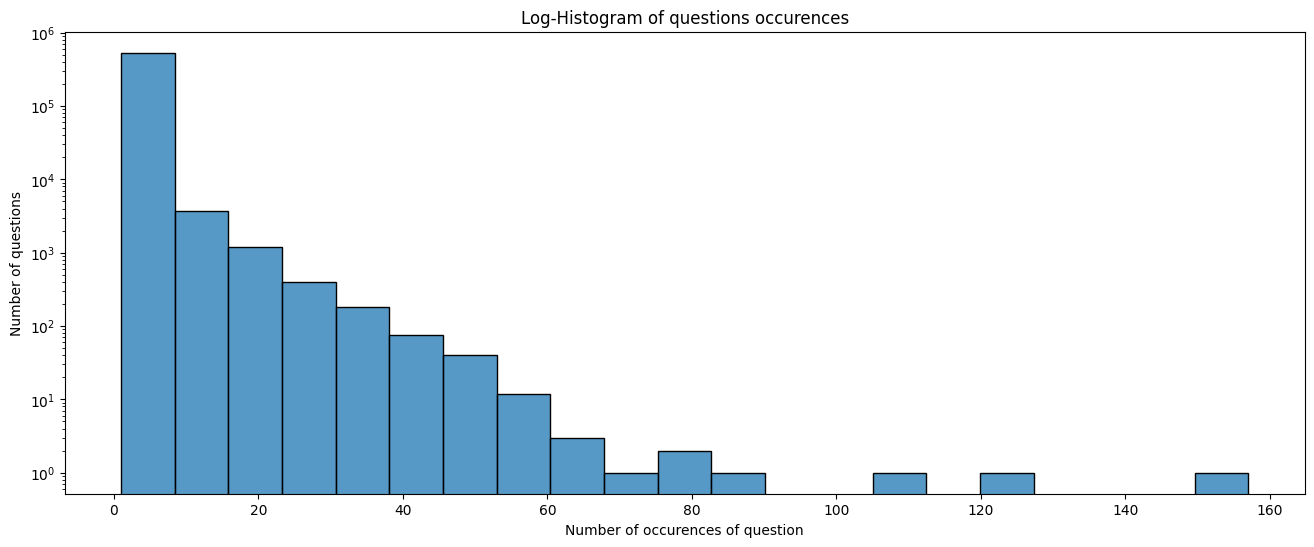

In [211]:
fig = plt.figure(figsize=(16, 6))

ax = sns.histplot(qids.value_counts())
ax.set_yscale('log')

ax.set_title('Log-Histogram of questions occurences')
ax.set_ylabel('Number of questions')
ax.set_xlabel('Number of occurences of question')

ax.bar_label(ax.containers[0]) # not working

plt.show()


### 4. Preprocessing

In [258]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove('not')

def preprocess(x):
    # 0. Convert to string
    x = str(x)
    
    # 1. Lower casing
    x = x.lower()
    
    # 2. Remove HTML tags
    re_html_tag = re.compile(r'<.*?>')
    x = re_html_tag.sub(r'', x)
    
    # 3. Remove URLs
    re_url = re.compile(r'https://\S+|www\.\S+')
    x = re_url.sub(r'', x)
    
    # 4. Expand contractions
    x = x.replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")    
    
    # 5. Number to units
    x = x.replace(",000,000,000", "b").replace(",000,000", "m").replace(",000", "k")
    
    # 6. Remove punctuations
    x = "".join([i for i in x if i not in string.punctuation ])
    
    # 7. Remove stopwords
    x = " ".join([word for word in x.split() if word not in STOPWORDS])
    
    # 8. Lemmatization
    lemmatizer = WordNetLemmatizer()
    x = " ".join([lemmatizer.lemmatize(word) for word in x.split()])

    return x

In [275]:
data.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [274]:
processed_data = data.copy()

In [276]:
start = datetime.now()
#for row in tqdm(processed_data[:100]):
processed_data['question1'] = processed_data['question1'].fillna("").apply(preprocess)
processed_data['question2'] = processed_data['question2'].fillna("").apply(preprocess)
print('Completed.\nTime taken: {0}'.format(datetime.now()-start))

Completed.
Time taken: 0:00:34.101343


#### 5. Export Data

In [277]:
processed_data

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math2324math divided 2423,0
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0
...,...,...,...,...,...,...
404285,404285,433578,379845,many keywords racket programming language late...,many keywords perl programming language latest...,0
404286,404286,18840,155606,believe life death,true life death,1
404287,404287,537928,537929,one coin,coin,0
404288,404288,537930,537931,approx annual cost living studying uic chicago...,little hairfall problem want use hair styling ...,0


In [278]:
data 

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [280]:
start = datetime.now()
processed_data.to_csv("../data/processed/processed_data.csv", index=True)
print('Processed data is exported.\nTime taken: {0}'.format(datetime.now()-start))

Processed data is exported.
Time taken: 0:00:01.580767
